In [1]:
import MDAnalysis
from MDAnalysis import analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Number of peptides ####
##gromacs configuration file###
gro_file = 'fullsys.gro'
##compressed trajectory file###
trajectory_file = 'final.xtc'
u = MDAnalysis.Universe('%s'%gro_file, '%s'%trajectory_file)
##### Sim start and sim end time
start = 0 
end = 200

In [3]:
################################# INSERT INFO FOR PEPTIDE1 ##########################################
peptide1 = dict()
#### Single letter sequence #####
peptide1['sequence'] = 'LLPIVGNLLKSLL'
#### Peptide name #####
peptide1['peptide_name'] = 'Temporin B'
#### Number of peptides #####
peptide1['pepnum'] = 4
### DO NOT EDIT ###
peptide1['resnum'] = len(peptide1['sequence'])
peptide1['restot'] = peptide1['pepnum']*peptide1['resnum']
peptide1['starting_resid'] = 1

In [4]:
################################# INSERT INFO FOR PEPTIDE2 ##########################################
peptide2 = dict()
#### Single letter sequence #####
peptide2['sequence'] = 'FVQWFSKFLGRIL'
#### Peptide name #####
peptide2['peptide_name'] = 'Temporin L'
#### Number of peptides #####
peptide2['pepnum'] = 4
### DO NOT EDIT ###
peptide2['resnum'] = len(peptide2['sequence'])
peptide2['starting_resid'] = peptide1['restot']+1
peptide2['restot'] = peptide2['starting_resid'] + (peptide2['pepnum']*peptide2['resnum'])

In [5]:
#Select peptides - Test with combinations of peptides with different sizes (should work though!!)
def select_peptides(peptide_list):
    peptide_selections = []
    for peptide in peptide_list:
        for i in range(0,peptide['pepnum']):
            start = (i*peptide['resnum']) + peptide['starting_resid']
            end = (i+1)*peptide['resnum'] + (peptide['starting_resid']-1)
            selection = "resid %s"%start + ":%s"%end
            peptide_selections.append(selection)
    return peptide_selections
peptide_selections = select_peptides([peptide1,peptide2])

In [6]:
peptide_selections

['resid 1:13',
 'resid 14:26',
 'resid 27:39',
 'resid 40:52',
 'resid 53:65',
 'resid 66:78',
 'resid 79:91',
 'resid 92:104']

In [7]:
# Use networkx to find connectivity using graph theory
import networkx 
from networkx.algorithms.components.connected import connected_components


def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    



In [8]:
def cluster_analysis(peptide_selections):
    import MDAnalysis.analysis.distances
    aggregate_list = []
    aggregate_final = []
    clust_max = []
    clust_num =[]
    for ts in u.trajectory[0::50]:
        #loop through one iterator
        aggregate_list = []

        for i in range(0,len(peptide_selections)):
            #loop through second iterator
            for j in range(i,len(peptide_selections)):
                if i != j:
                    #Selection and distasnce calculation
                    selection1 = u.select_atoms('%s'%peptide_selections[i]).positions
                    selection2 = u.select_atoms('%s'%peptide_selections[j]).positions
                    dist = MDAnalysis.analysis.distances.distance_array(selection1, selection2, 
                                                                        box=None, result=None, backend='serial')
                    min_dist = np.min(dist)
                    #Apply cut off of 6 angstrom - could this be stratified better?
                    if min_dist < 6:
                        aggregate_list.append([i+1,j+1])

        #Run graphing and connectivity analysis
        G = to_graph(aggregate_list)
        cluster = list((connected_components(G)))
        aggregate_final.append(cluster)
        #Calculate number of custers
        clust_num.append([u.trajectory.time,len(cluster)])
        #Calculate largest cluster
        #set as 0 to allow np.max later
        clust_size = [0]
        for clust in cluster:
            clust_size.append((len(list(clust))))
        clust_max.append([u.trajectory.time,np.max(clust_size)])
    return clust_max,clust_num,aggregate_final

#Call function, return varibles
max_clust_size,number_of_clusters,cluster_ids = cluster_analysis(peptide_selections)

In [9]:
cluster_ids

[[],
 [],
 [],
 [{5, 8}],
 [{5, 8}],
 [],
 [{4, 6}, {5, 8}],
 [],
 [{1, 6}, {2, 7}, {5, 8}],
 [{1, 6}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {4, 6}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{1, 3}, {2, 7}, {5, 8}],
 [{1, 3}, {2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{1, 4}, {2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{2, 7}, {5, 8}],
 [{5, 8}],
 [{5, 8}],
 [{5, 8}],
 [{5, 8}],
 [{5, 8}],
 [{1, 6}, {5, 8}],
 [{1, 6}, {5, 8}],
 [{1, 4, 6}, {5, 8}],
 [{1, 4}, {5, 8}],
 [{1, 4}, {5, 8}],
 [{1, 4}, {5, 8}],
 [{1, 4}],
 [{1, 4}, {5, 8}],
 [{1, 4}, {5, 8}],
 [{1, 4}, {5, 8}],
 [{1, 4}, {5, 8}],
 [{1, 4, 6}, {5, 8}],
 [{1, 4, 6}, {5, 8}],
 [{1, 4, 6}, {5, 8}],
 [{1, 4, 6}, {3, 5, 8}],
 [{1, 4, 6}, {3, 5, 8}],
 [{1, 4, 6}, {5, 7, 8}],
 [{1, 4, 6}, {5, 7, 8}],
 [{1, 4, 6}, {3, 5, 8}],
 [{1, 4, 6}, {3, 5, 8}],
 [{1, 4, 

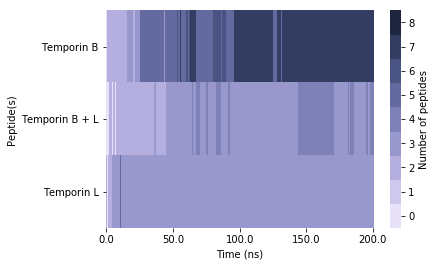

In [10]:
#Create pandas dataframe for maximum cluster size
synergy_size = pd.DataFrame(max_clust_size)
synergy_size.columns=['Time (ns)','Maximum aggregate size (n peptide)']
synergy_size['Peptide'] = "Temporin B + L"
synergy_size['Time (ns)'] = synergy_size['Time (ns)']/1000

#Load in seperate peptides - Could this be tidied up?
headers = ['Time (ns)','Maximum aggregate size (n peptide)']
#peptide1
Temporin_B = pd.read_csv('max_clust_size_Temporin B.csv',names=headers)
Temporin_B['Peptide'] = "Temporin B"
Temporin_B['Time (ns)'] = Temporin_B['Time (ns)']/1000
#peptide2
Temporin_L = pd.read_csv('max_clust_size_Temporin L.csv',names=headers)
Temporin_L['Peptide'] = "Temporin L"
Temporin_L['Time (ns)'] = Temporin_L['Time (ns)']/1000
#Combine
max_size = pd.concat([synergy_size,Temporin_B,Temporin_L])
#pvid from long to wide for heatmap plotting
max_heatmap =  max_size.pivot(index='Peptide', columns='Time (ns)', values='Maximum aggregate size (n peptide)')

#######PLOT HEATMAP############################
from matplotlib.colors import LinearSegmentedColormap
#Create colorbar - alternative colormaps seems to mess up figure. Why???
cmap = sns.cubehelix_palette(start=2.8, rot=.1, light=0.9, n_colors=9)

#Create seaborn plot
ax = sns.heatmap(max_heatmap, cmap=cmap,yticklabels=1,xticklabels=50,cbar_kws={'label': 'Number of peptides'},vmin=0,vmax=9)

# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])

# set labels
colorbar.set_ticklabels(list(range(0,9)))
#center tick labels          
#ax.set_yticklabels(['Temporin B', 'Temporin L','Temporin B+L'], 
                   #va='center', rotation = 90, position=(0,0.28))
plt.ylabel('Peptide(s)')
plt.xlabel('Time (ns)')
plt.xlim(0,201)
plt.savefig('max_size.png',dpi=300,bbox_inches="tight")


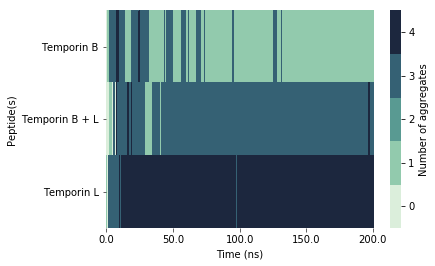

In [11]:
#Create pandas dataframe for maximum cluster size
synergy_num = pd.DataFrame(number_of_clusters)
synergy_num.columns=['Time (ns)','Number of aggregates']
synergy_num['Peptide'] = "Temporin B + L"
synergy_num['Time (ns)'] = synergy_size['Time (ns)']

#Load in seperate peptides - Could this be tidied up?
headers = ['Time (ns)','Number of aggregates']
#peptide1
Temporin_B = pd.read_csv('number_of_clusters_temporin B.csv',names=headers)
Temporin_B['Peptide'] = "Temporin B"
Temporin_B['Time (ns)'] = Temporin_B['Time (ns)']/1000
#peptide2
Temporin_L = pd.read_csv('number_of_clusters_temporin L.csv',names=headers)
Temporin_L['Peptide'] = "Temporin L"
Temporin_L['Time (ns)'] = Temporin_L['Time (ns)']/1000
#Combine
num_size = pd.concat([synergy_num,Temporin_B,Temporin_L])
#pvid from long to wide for heatmap plotting
num_heatmap =  num_size.pivot(index='Peptide', columns='Time (ns)', values='Number of aggregates')

#######PLOT HEATMAP############################
from matplotlib.colors import LinearSegmentedColormap
#Create colorbar - alternative colormaps seems to mess up figure. Why???
cmap = sns.cubehelix_palette(rot=-.4, light=0.9, n_colors=5)

#Create seaborn plot
ax = sns.heatmap(num_heatmap, cmap=cmap,yticklabels=1,xticklabels=50,cbar_kws={'label': 'Number of aggregates'},vmin=0,vmax=3)

# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.3,0.9,1.5,2.1,2.7])

# set labels
colorbar.set_ticklabels(list(range(0,5)))
#center tick labels          
#ax.set_yticklabels(['Temporin B', 'Temporin L','Temporin B+L'], 
                   #va='center', rotation = 90, position=(0,0.28))
plt.ylabel('Peptide(s)')
plt.xlabel('Time (ns)')
plt.xlim(0,201)
plt.tick_params(
    which='both', 
    width = 0.6,
    bottom=True,
    left=True,
    labelbottom=True) 
plt.savefig('num_clust.png',dpi=300,bbox_inches="tight")
